In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
import pandas as pd
import pickle as pkl
import seaborn as sns
import matplotlib as mpl

# Plot Formatting

In [3]:
# clrs = sns.color_palette('Set1')
# clrs[5] = (255/255, 200/255, 80/255)
# colors = cycler('color', list(clrs.as_hex()))
mpl.rc('font', family='serif')
# #mpl.rc('text', usetex=True)

plt.rc('axes', axisbelow=True, 
       grid=False)#, prop_cycle=colors)
plt.rc('xtick', direction='in')
plt.rc('ytick', direction='in')
# plt.rcParams['figure.dpi'] = 75

# Convenience Functions

In [9]:
def mask_contamination(labline, mask_dict):
    mask_idx = mask_dict[labline]
    if isinstance(mask_idx, list):
        mask=np.ones(300, dtype=bool)
        mask[mask_idx[0]:mask_idx[1]] = False
        return mask
    else:
        mask=np.zeros(300, dtype=bool)
        mask[mask_idx:] = True
        return mask
    
# labline: mask array
line_mask_dict = {
    1453.1:200,
    1555.89:[75,175],
    1463.83:200,
    1613.72:[75,200],
    1415.33:180,
    1407.29:200,
    1468.39:[75,299], #mask out MgII transition at 1466.55
    1407.29: [75,250],
    1435.05: [80,299], #High velocity component
    1636.34: [75,190]
}

# Read in Data

In [4]:
line_df = pd.read_pickle(os.path.join('data', 'line_df_local.pkl'))
blue_df = pd.read_pickle(os.path.join('data', 'blue_df.pkl'))
red_df = pd.read_pickle(os.path.join('data', 'red_df.pkl'))

In [5]:
prog_df = pd.read_pickle(os.path.join('data', 'line_prog_df_local.pkl'))
blue_df = pd.read_pickle(os.path.join('data', 'blue_prog_df.pkl'))
red_df = pd.read_pickle(os.path.join('data', 'red_prog_df.pkl'))

# Fit Comparisons

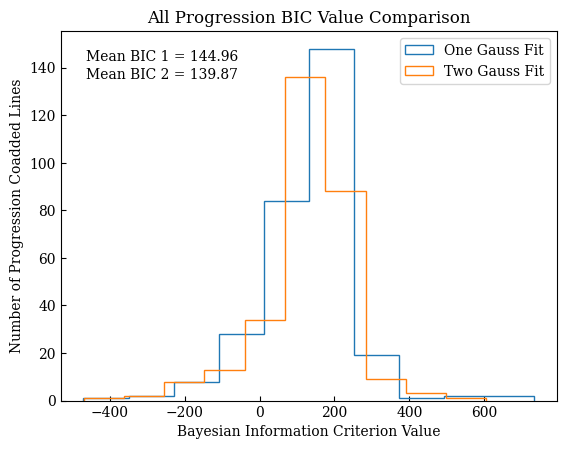

In [6]:
BIC1_mean = np.mean(prog_df['BIC1'])
BIC2_mean = np.mean(prog_df['BIC2'])
plt.hist(line_df['BIC1'], histtype='step', label='One Gauss Fit')
plt.hist(line_df['BIC2'], histtype='step', label='Two Gauss Fit')
plt.legend()
plt.xlabel('Bayesian Information Criterion Value')
plt.ylabel('Number of Progression Coadded Lines')
plt.title('All Progression BIC Value Comparison')
plt.text(0.05, 0.95, f'Mean BIC 1 = {BIC1_mean:0.2f}',
                            transform=plt.gca().transAxes, verticalalignment='top')
plt.text(0.05, 0.90, f'Mean BIC 2 = {BIC2_mean:0.2f}',
                            transform=plt.gca().transAxes, verticalalignment='top')
plt.show()

In [ ]:
for transition in line_df['transition'].unique():
    BIC1_mean = np.mean(line_df[line_df['transition']==transition]['BIC1'])
    BIC2_mean = np.mean(line_df[line_df['transition']==transition]['BIC2'])
    plt.hist(line_df[line_df['transition']==transition]['BIC1'], histtype='step', label='One Gauss Fit')
    plt.hist(line_df[line_df['transition']==transition]['BIC2'], histtype='step', label='Two Gauss Fit')
    plt.legend()
    plt.xlabel('Bayesian Information Criterion Value')
    plt.ylabel('Number of Progression Coadded Lines')
    plt.title(f'{transition} BIC Value Comparison')
    plt.text(0.05, 0.95, f'Mean BIC 1 = {BIC1_mean:0.2f}',
                                transform=plt.gca().transAxes, verticalalignment='top')
    plt.text(0.05, 0.90, f'Mean BIC 2 = {BIC2_mean:0.2f}',
                                transform=plt.gca().transAxes, verticalalignment='top')
    plt.show()

In [ ]:
for transition in blue_df['transition'].unique():
    BIC1_mean = np.mean(blue_df[blue_df['transition']==transition]['BIC1'])
    BIC2_mean = np.mean(blue_df[blue_df['transition']==transition]['BIC2'])
    plt.hist(blue_df[blue_df['transition']==transition]['BIC1'], histtype='step', label='One Gauss Fit')
    plt.hist(blue_df[blue_df['transition']==transition]['BIC2'], histtype='step', label='Two Gauss Fit')
    plt.legend()
    plt.xlabel('Bayesian Information Criterion Value')
    plt.ylabel('Number of Progression Coadded Lines')
    plt.title(f'{transition} BIC Value Comparison')
    plt.text(0.05, 0.95, f'Mean BIC 1 = {BIC1_mean:0.2f}',
                                transform=plt.gca().transAxes, verticalalignment='top')
    plt.text(0.05, 0.90, f'Mean BIC 2 = {BIC2_mean:0.2f}',
                                transform=plt.gca().transAxes, verticalalignment='top')
    plt.show()

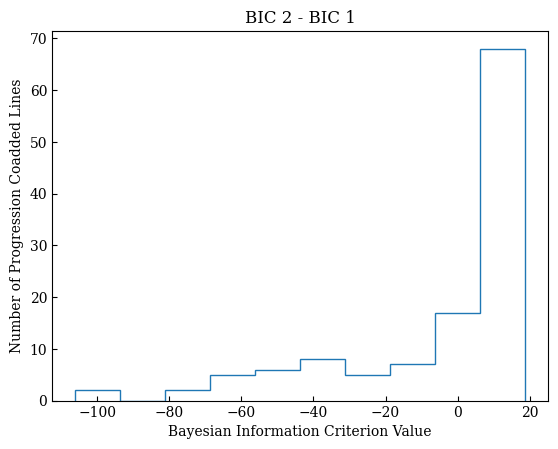

In [11]:
plt.hist(prog_df['BIC2']-prog_df['BIC1'], histtype='step', label='Model BIC comparison')
plt.xlabel('Bayesian Information Criterion Value')
plt.ylabel('Number of Progression Coadded Lines')
plt.title('BIC 2 - BIC 1')
plt.show()

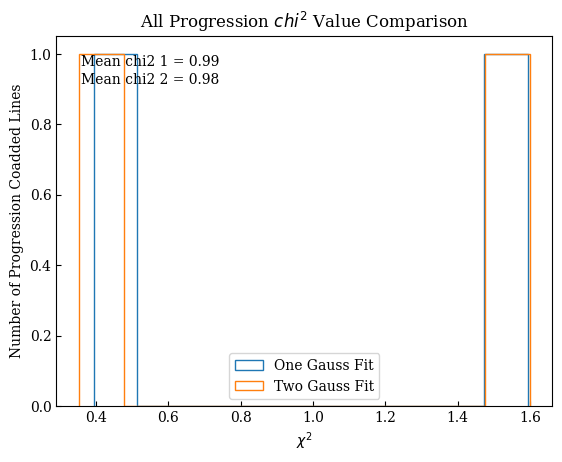

In [12]:
def calculate_chi2(df):
    chi2_single = []
    chi2_double = []
    red_chi2_single = []
    red_chi2_double = []

    for _, row in df.iterrows():
        f_obs = np.array(row['flux'], dtype=float)
        f_err = np.array(row['fluxerr'], dtype=float)
        f_model_single = np.array(row['gauss_flux'], dtype=float)
        f_model_double = np.array(row['double_gauss_flux'], dtype=float)

        # apply mask if labline has one
        if row['labline'] in line_mask_dict.keys():
            mask = mask_contamination(row['labline'], line_mask_dict)
            f_obs = f_obs[~mask]
            f_err = f_err[~mask]

        chi2_1 = np.sum(((f_obs - f_model_single) / f_err) ** 2)
        chi2_2 = np.sum(((f_obs - f_model_double) / f_err) ** 2)
        chi2_single.append(chi2_1)
        chi2_double.append(chi2_2)

        #calculate reeduced chi2
        red_chi2_1 = chi2_1/(len(f_obs) - len(row['params1']))
        red_chi2_2 = chi2_2/(len(f_obs) - len(row['params2']))
        red_chi2_single.append(red_chi2_1)
        red_chi2_double.append(red_chi2_2)

    return red_chi2_single, red_chi2_double

red_chi2_single, red_chi2_double = calculate_chi2(blue_df)
chi21_mean = np.mean(red_chi2_single)
chi22_mean = np.mean(red_chi2_double)
plt.hist(red_chi2_single, histtype='step', label='One Gauss Fit')
plt.hist(red_chi2_double, histtype='step', label='Two Gauss Fit')
plt.legend()
plt.xlabel(r'$\chi^2$')
plt.ylabel('Number of Progression Coadded Lines')
plt.title(r'All Progression $chi^2$ Value Comparison')
plt.text(0.05, 0.95, f'Mean chi2 1 = {chi21_mean:0.2f}',
                            transform=plt.gca().transAxes, verticalalignment='top')
plt.text(0.05, 0.90, f'Mean chi2 2 = {chi22_mean:0.2f}',
                            transform=plt.gca().transAxes, verticalalignment='top')
plt.show()

# Residuals

# Time series Parameter Plots

In [ ]:
# Initialize fit_dict from the first row
params1_keys = line_df.iloc[0]['params1'].keys()
params2_keys = line_df.iloc[0]['params2'].keys()

# Loop through each unique (transition, labline) pair
for (transition, labline), sub_df in line_df.groupby(['transition', 'labline']):
    par_dict1 = {k: [] for k in params1_keys}
    err_dict1 = {k: [] for k in params1_keys}
    par_dict2 = {k: [] for k in params2_keys}
    err_dict2 = {k: [] for k in params2_keys}

    obsdates = pd.to_datetime(sub_df['obsdate']).dt.strftime("%Y-%m-%d").tolist()
    x_vals = range(len(obsdates))

    # Extract parameter values and uncertainties
    for _, row in sub_df.iterrows():
        for k, (val, err) in row['params1'].items():
            par_dict1[k].append(val)
            err_dict1[k].append(np.nan if err is None else err)
        for k, (val, err) in row['params2'].items():
            par_dict2[k].append(val)
            err_dict2[k].append(np.nan if err is None else err)

    # --- Plot single Gaussian (params1) ---
    fig, ax = plt.subplots(1, len(params1_keys), figsize=(20, 7), layout='constrained')
    if len(params1_keys) == 1:
        ax = [ax]  # make iterable

    for i, key in enumerate(params1_keys):
        vals = np.array(par_dict1[key], dtype=float)
        errs = np.array(err_dict1[key], dtype=float)

        ax[i].errorbar(x_vals, vals, yerr=errs, marker='o')
        ax[i].set_ylabel(key)
        ax[i].set_xlabel('Date')
        ax[i].set_xticks(x_vals)
        ax[i].set_xticklabels(obsdates, rotation=60, fontsize=8)

        # --- Apply robust y-limits (ignore extreme errorbars) ---
        finite_vals = vals[np.isfinite(vals)]
        if len(finite_vals) > 0:
            median = np.nanmedian(finite_vals)
            iqr = np.nanpercentile(finite_vals, 75) - np.nanpercentile(finite_vals, 25)
            # Limit to median ± 3×IQR (covers most normal variation)
            ax[i].set_ylim(median - 3 * iqr, median + 3 * iqr)

    fig.suptitle(f"{transition}  |  λ = {labline}")
    fig.show()

    # --- Plot double Gaussian (params2) ---
    fig2, ax2 = plt.subplots(1, len(params2_keys), figsize=(25, 7), layout='constrained')
    if len(params2_keys) == 1:
        ax2 = [ax2]

    for i, key in enumerate(params2_keys):
        vals = np.array(par_dict2[key], dtype=float)
        errs = np.array(err_dict2[key], dtype=float)

        ax2[i].errorbar(x_vals, vals, yerr=errs, marker='o')
        ax2[i].set_ylabel(key)
        ax2[i].set_xlabel('Date')
        ax2[i].set_xticks(x_vals)
        ax2[i].set_xticklabels(obsdates, rotation=60, fontsize=10)

        # --- Robust y-limits ---
        finite_vals = vals[np.isfinite(vals)]
        if len(finite_vals) > 0:
            median = np.nanmedian(finite_vals)
            iqr = np.nanpercentile(finite_vals, 75) - np.nanpercentile(finite_vals, 25)
            ax2[i].set_ylim(median - 5 * iqr, median + 5 * iqr)

    fig2.suptitle(f"{transition}  |  λ = {labline}")
    fig2.show()